# Курсовий проект. Тема "Перегляд реклами"
* Метою цього проєкту є аналіз ефективності показу онлайн-реклами. 
* Основнa задача: Побудова моделі для прогнозування кількості переглядів залежно від часу, типу реклами та інших параметрів.

**Завдання**
1. **EDA (Exploratory Data Analysis)**:
   - Проаналізуйте дані на наявність трендів, сезонності та аномалій.   
   - Візуалізуйте дані (часові графіки, гістограми, теплові карти тощо).  

2. **Попередня обробка**:
   - Врахуйте аномалії у даних: визначте, чи потрібно їх видалити, згладити або моделювати окремо.

3. **Прогнозування**:
   - Використовуйте оброблені дані для створення моделі прогнозування на 7 днів наперед.  
   - Виберіть модель, яка враховує тренди та сезонність (наприклад, ARIMA, Prophet або LSTM).  

4. **Оцінка результатів**:
   - Перевірте якість прогнозу, використовуючи метрики (наприклад, RMSE, MAE).  
   - Інтерпретуйте отриманий прогноз і перевірте, як модель справляється з аномаліями.
  
Дані: набір містить інформацію про кількість перегрлядів реклами під час комп'ютерної гри. Дані агреговані погодинно.

# Виконання

#### Завантажуємо дані та спостерігаємо

In [365]:
import pandas as pd
data = pd.read_csv('data/ads.csv')
data['Time'] = pd.to_datetime(data['Time'])
data.set_index('Time', inplace=True)
data.head()


,Ads
Time,
2017-09-13 00:00:00,80115
2017-09-13 01:00:00,79885
2017-09-13 02:00:00,89325
2017-09-13 03:00:00,101930
2017-09-13 04:00:00,121630


<Axes: xlabel='Time'>

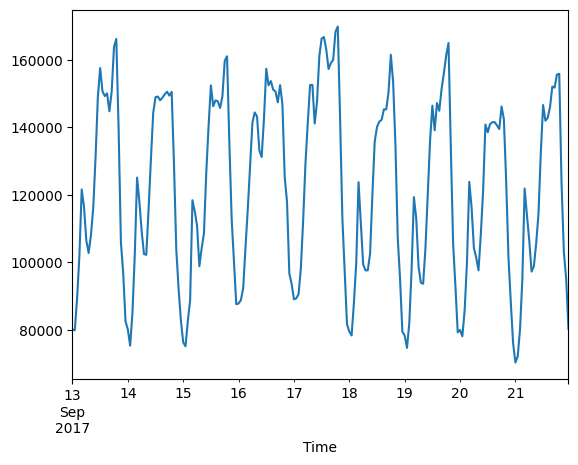

In [366]:
data['Ads'].plot()

#### Аналізуємо дані
**Виявлені деталі**
* Дані рівномірні та без пропусків - передобробка не потрібна.
* Явний тренд відсутній - можна його не виділяти.
* Існує явно виражена сезонність, два рівня, більша - добова, та менша - приблизно 3-4 аплітуди на добу - необхідно їх виділити.

**Рішення**
* На всяк випадок зробимо ADF тест щоб впевнитися що ряд стаціонарний.
* Так як вже існує хоча б одна явно виражена компонента - треба виділити компоненти тренду, сезонності і шуму всі разом і проаналізувати їх окремо.

#### Перевіряємо ряд на стаціонарність

In [367]:
from statsmodels.tsa.stattools import adfuller
stability = adfuller(data.dropna())

print(f"ADF Statistic: {stability[0]}")
print(f"p-value: {stability[1]}")
print(f"Timeseries is", "STABLE" if stability[1] < 0.05 else "UNSTABLE")

ADF Statistic: -7.089633890638511
p-value: 4.4448036886224977e-10
Timeseries is STABLE


**Виявлені деталі**
* Ряд стаціонарний - диференціювати не потрібно

#### Виділяємо сезонність

<Axes: xlabel='Time'>

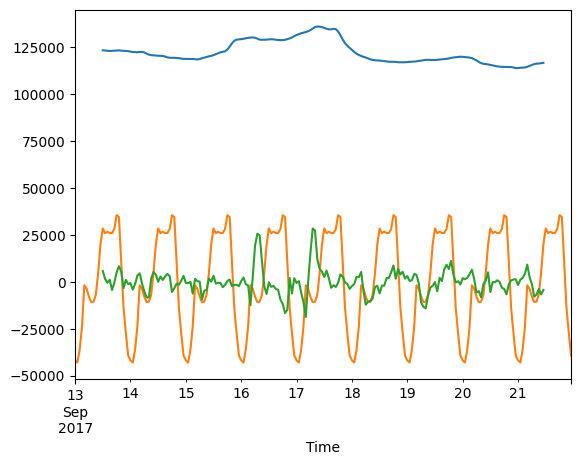

In [368]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition_result = seasonal_decompose(data, period=24)

decomposition_trend = decomposition_result.trend.dropna()
decomposition_seasonal = decomposition_result.seasonal.dropna()
decomposition_residuals = decomposition_result.resid.dropna()

decomposition_trend.plot()
decomposition_seasonal.plot()
decomposition_residuals.plot()

In [369]:
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

correlation = np.corrcoef(decomposition_trend, decomposition_residuals)[0, 1]
print(f"Кореляція між трендом і шумами: {correlation:.4f}")

Кореляція між трендом і шумами: 0.1536


Mean: -54.6897, Std: 6694.6272
Data is depended (is not noise): TRUE


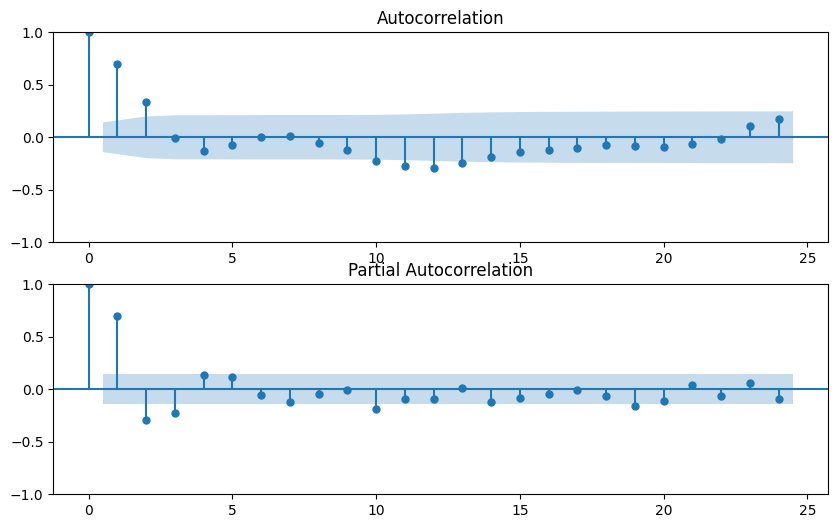

In [370]:
mean_residuals = decomposition_residuals.mean()
std_residuals = decomposition_residuals.std()
print(f"Mean: {mean_residuals:.4f}, Std: {std_residuals:.4f}")

from statsmodels.stats.diagnostic import acorr_ljungbox
lb_test = acorr_ljungbox(decomposition_residuals, lags=[24], return_df=True)
print("Data is depended (is not noise):", "TRUE" if lb_test["lb_pvalue"].values[0] < 0.05 else "FALSE")

fig, axes = plt.subplots(2, 1, figsize=(10, 6))
plot_acf(decomposition_residuals, lags=24, ax=axes[0])
plot_pacf(decomposition_residuals, lags=24, ax=axes[1])
plt.show()

**Виявлені деталі**
* Сезонність дуже чітка і стабільна - можна застосувати метод Furier Transformation який чітко виділить гармоніки.
* Тренд - вже ж таки має неочікуванні скачки, є підозра що вони корелюють зі скачками на шумах, але кореляція це не підтвердила, тому розглядаємо їх окремо.
* Шуми не схожі на реальний шум - Ljung-Box тест це підтверджує (є залежність від попередніх значень) та mean != 0 що значить що є постійне зміщення - треба буде використовувати ARIMA для прогнозування. Визначемо параметри p, d, q. Ряд стаціонарний, тому d = 1 - не робимо диференціяцію. Автокореляція показує що лаг = 2 найбільше впливають на поточне значения, тому q = 2. Часткова автокореляція показує, що після перших двух значень різко падає кореляція, а тому 2й лаг це є той лаг з якого можно визначати авторегресію.
* Тренд може бути або просто аномалією або циклічним трендом який не видно в масштабі наданих даних (більше місяця). За допомогою Furier Transformation спробуємо отримати якусь одну вагому частоту - якщо буде - то це все ж таки сезонність, якщо ні - аномалія.

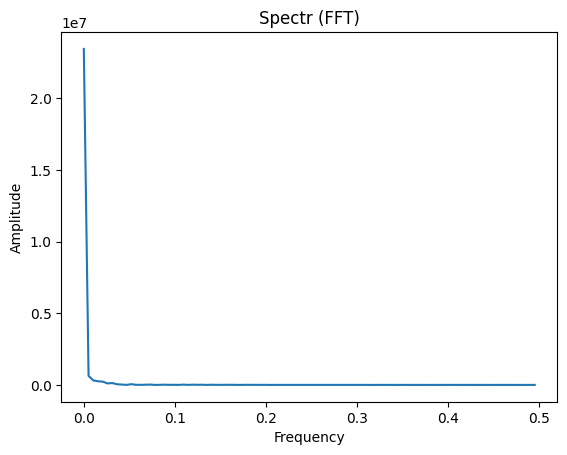

In [371]:
fft_result = np.fft.fft(decomposition_trend)
freqs = np.fft.fftfreq(len(decomposition_trend))

half_len = len(decomposition_trend) // 2 
plt.plot(freqs[:half_len], np.abs(fft_result)[:half_len])
plt.title("Spectr (FFT)")
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.show()

**Виявлені деталі**
* Частот виражених не має - це аномалія, ми її пронозувати не будемо і в якості тренда візьмемо його середнє значення для прогнозу 

#### Прогнозуємо компоненти

                               SARIMAX Results                                
Dep. Variable:                  resid   No. Observations:                  192
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -1881.148
Date:                Fri, 07 Feb 2025   AIC                           3774.296
Time:                        14:45:50   BIC                           3793.841
Sample:                    09-13-2017   HQIC                          3782.211
                         - 09-21-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -54.6897    806.084     -0.068      0.946   -1634.586    1525.207
ar.L1          0.7920      0.148      5.358      0.000       0.502       1.082
ar.L2         -0.4310      0.113     -3.831      0.0

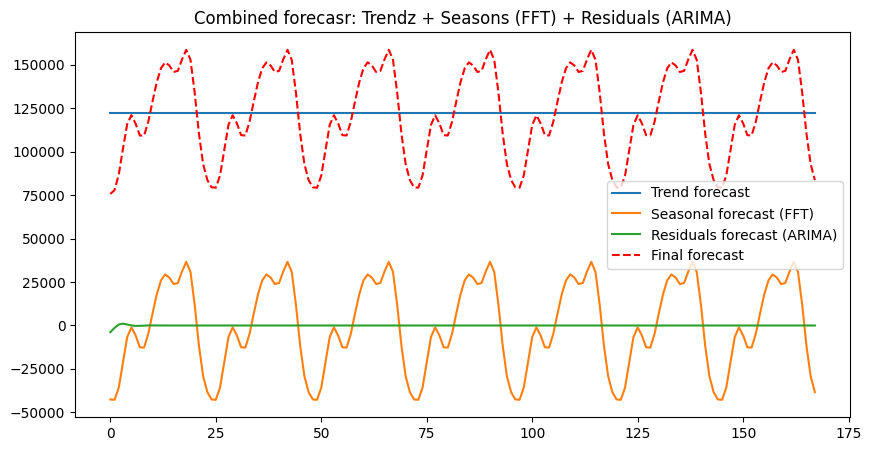

In [372]:
forecast_horizon = 24 * 7

# Trend
trend_mean = decomposition_trend.mean()
future_trend = np.full(forecast_horizon, trend_mean)

# Seasons
initial_data_len = len(decomposition_seasonal)
fft_result = np.fft.fft(decomposition_seasonal)
freqs = np.fft.fftfreq(initial_data_len)
top_k = 10
indices = np.argsort(np.abs(fft_result))[-top_k:]
filtered_fft = np.zeros_like(fft_result, dtype=complex)
filtered_fft[indices] = fft_result[indices]
extended_time = np.arange(initial_data_len + forecast_horizon)
future_seasonal = np.fft.ifft(filtered_fft).real[-forecast_horizon:]

# Residuals
decomposition_residuals = decomposition_residuals.copy() 
decomposition_residuals.index = pd.date_range(
    start=decomposition_residuals.index[0], periods=len(decomposition_residuals), freq="h"
)

from statsmodels.tsa.arima.model import ARIMA
arima_model = ARIMA(decomposition_residuals.dropna(), order=(2, 0, 2))
arima_result = arima_model.fit()
print(arima_result.summary())
future_residuals = arima_result.forecast(steps=forecast_horizon)

final_forecast = future_trend + future_seasonal + future_residuals

plt.figure(figsize=(10, 5))
plt.plot(np.arange(forecast_horizon), future_trend, label="Trend forecast")
plt.plot(np.arange(forecast_horizon), future_seasonal, label="Seasonal forecast (FFT)")
plt.plot(np.arange(forecast_horizon), future_residuals, label="Residuals forecast (ARIMA)")
plt.plot(np.arange(forecast_horizon), final_forecast, label="Final forecast", linestyle="dashed", color="red")
plt.legend()
plt.title("Combined forecasr: Trendz + Seasons (FFT) + Residuals (ARIMA)")
plt.show()

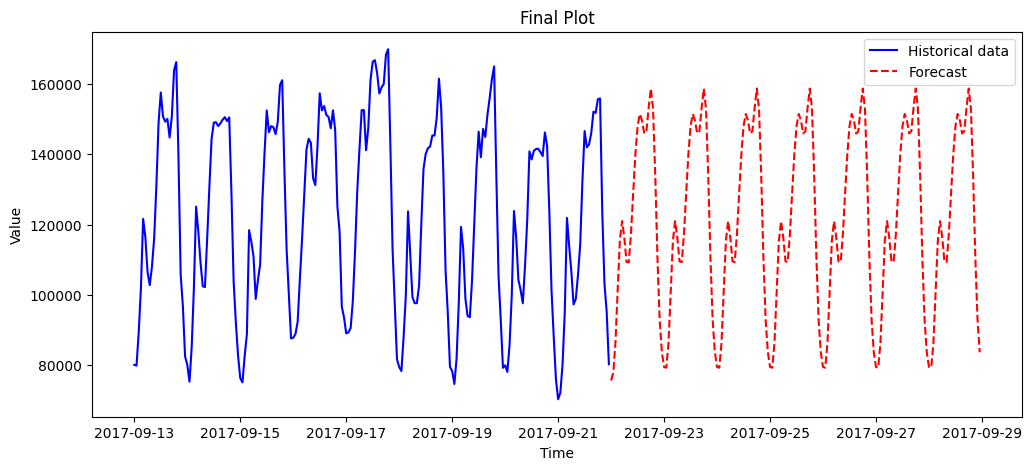

In [373]:
future_dates = pd.date_range(start=data.index[-1], periods=len(final_forecast)+1, freq='h')[1:]
plt.figure(figsize=(12, 5))
plt.plot(data.index, data['Ads'], label="Historical data", color="blue")
plt.plot(future_dates, final_forecast, label="Forecast", linestyle="dashed", color="red")

plt.legend()
plt.title("Final Plot")
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()